In [1]:
import pickle 
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
location = '/Users/perudornellas/python/imperial/cx1_am_kit/multiscale_tests/'

In [2]:
lattice_files = os.listdir(f'{location}results/lattices')
property_files = os.listdir(f'{location}results/properties')
lattice_files.sort(); property_files.sort()
# print(property_files)



n_systems = len(lattice_files)
print(n_systems)
params_file = '/Users/perudornellas/python/imperial/cx1_am_kit/multiscale_tests/run_params.pickle'

with open(params_file, 'rb') as f:
    plaquette_numbers = pickle.load(f)
    minimum_L, maximum_L , n_steps = pickle.load(f)


# restrict to a subset for testing - comment out for proper runs
# lim = 50
# lattice_files = lattice_files[:lim]
# property_files= property_files[:lim]
# n_systems = len(lattice_files)

# iterate over all the systems

all_energies = np.zeros([n_systems, n_steps])
all_gaps = np.zeros([n_systems, n_steps])
all_gap_diff = np.zeros([n_systems, n_steps])
all_participations = np.zeros([n_systems, n_steps])

for u, names in enumerate(zip(lattice_files, property_files)):
    f_name, p_name = names
    assert(f_name[1] == p_name[1])
    # open the relevant file

    gaps = np.zeros([n_steps, 4])   # gap size for each sector of toric space
    gap_differences = np.zeros(n_steps)     # difference between the gap size of the smallest and largest toric sector  
    energies = np.zeros(n_steps)    # energy of the system per site
    participations = np.zeros([n_steps])    # p ratio of the lowest energy state

    
    with open(location + 'results/lattices/' + f_name , 'rb') as f_lat, open(location + 'results/properties/' + p_name , 'rb') as f_res:
        for n in range(n_steps):
            # get energies over k space and participation ratios
            e_values, p_ratios, _ = pickle.load(f_res) 
            
            # find only the toric code sectors of energies
            indices = [0 , 10, 0 , 10] , [0 , 0 ,10 , 10]
            e_toric = e_values[ indices ]

            energies[n] = np.sum(np.abs(e_toric))/(4*e_values.shape[2])

            gaps[n] = np.min(np.abs(e_toric), axis=1)
            
            index_lowest_state = np.argmin(np.abs(e_toric), axis=1)[0]

            participations[n] = p_ratios[index_lowest_state,0]

            
    min_gap = np.min(gaps, axis=1)
    max_gap = np.max(gaps, axis=1)
    gap_differences = max_gap - min_gap

    all_gaps[u] = gaps[:,0]
    all_energies[u] = energies
    all_gap_diff[u] = gap_differences
    all_participations[u] = participations

    # ax[0].scatter(plaquette_numbers, energies)
    # ax[1].scatter(plaquette_numbers, min_gap, c= participations)
    # ax[2].scatter(plaquette_numbers, max_gap - min_gap)
    # ax[3].scatter(plaquette_numbers, participations)
    

            


1024


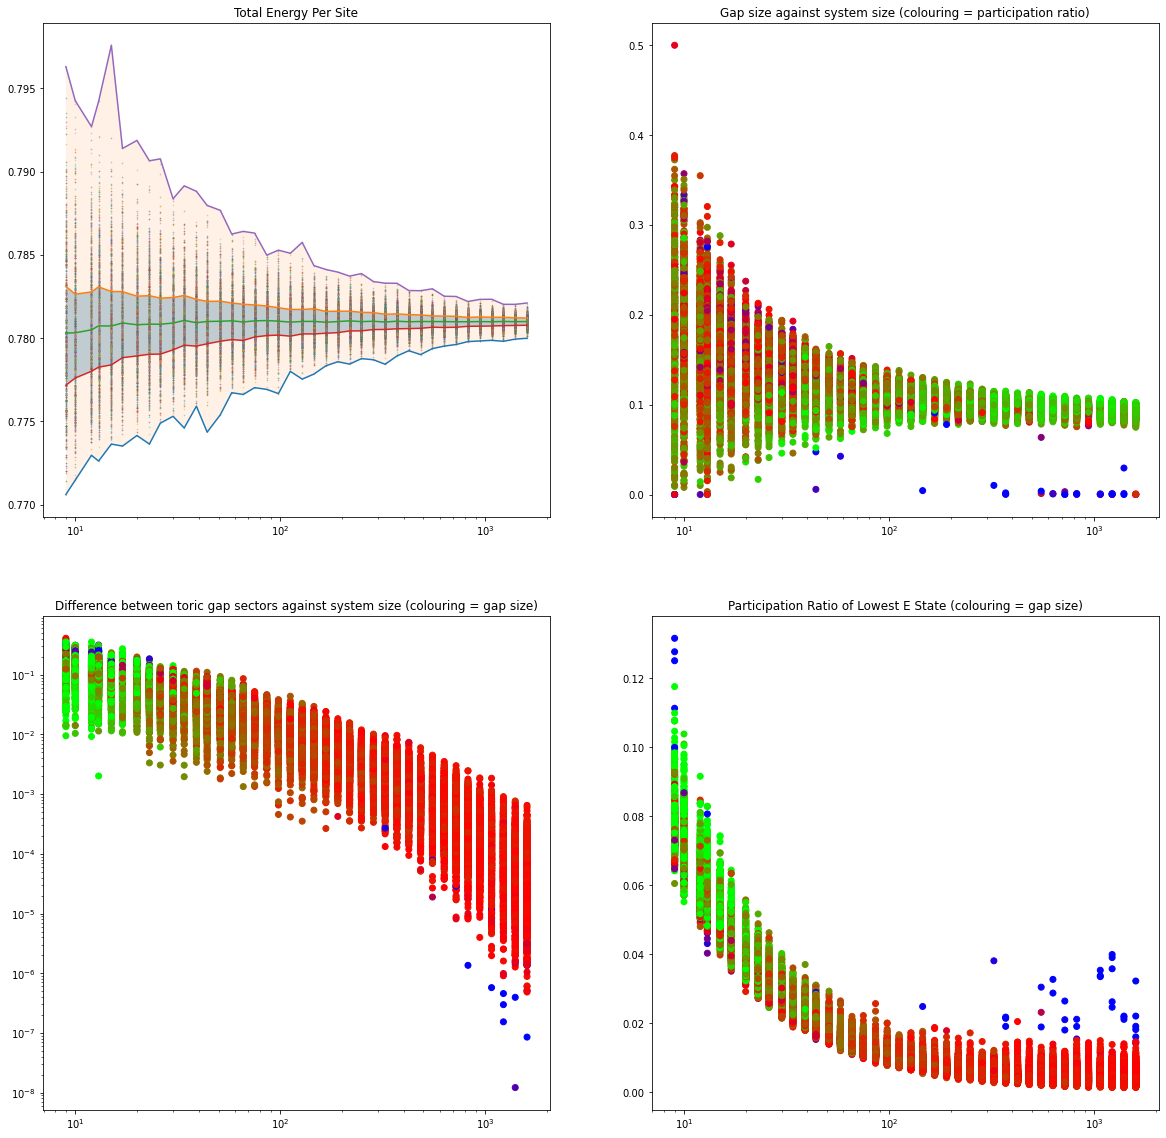

In [3]:
fig, ax = plt.subplots(2,2, figsize = (20,20))

ax= ax.flatten()
ax[0].set_xscale('log')
ax[0].set_title('Total Energy Per Site')

ax[1].set_title('Gap size against system size (colouring = participation ratio)')
ax[1].set_xscale('log')
# ax[1].set_yscale('log')

ax[2].set_title('Difference between toric gap sectors against system size (colouring = gap size)')
ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[3].set_title('Participation Ratio of Lowest E State (colouring = gap size)')
ax[3].set_xscale('log')
# ax[3].set_yscale('log')


p_max = np.max(all_participations, axis = 0)
p_min = np.min(all_participations, axis = 0)
p_dif = p_max-p_min

g_max = np.max(all_gaps, axis = 0)
g_min = np.min(all_gaps, axis = 0)
g_dif = g_max-g_min

energies_sorted = np.sort(all_energies, axis= 0)
energy_means = np.average(all_energies, axis= 0)

ax[0].plot(plaquette_numbers,energies_sorted[0,:])
ax[0].plot(plaquette_numbers,energies_sorted[(3*n_systems)//4,:])
ax[0].plot(plaquette_numbers,energy_means)
ax[0].fill_between(plaquette_numbers,energies_sorted[(n_systems)//4,:],energies_sorted[(3*n_systems)//4,:], alpha = 0.3)
ax[0].fill_between(plaquette_numbers,energies_sorted[0,:],energies_sorted[-1,:], alpha = 0.1)
ax[0].plot(plaquette_numbers,energies_sorted[(n_systems)//4,:])
ax[0].plot(plaquette_numbers,energies_sorted[-1,:])

for u in range(n_systems):
    ax[0].scatter(plaquette_numbers, all_energies[u], alpha = 0.4, s= 0.4)

    colouring = (all_participations[u] - p_min)/p_dif
    ax[1].scatter(plaquette_numbers, all_gaps[u], c= colouring, vmin = 0, vmax = 1, cmap = 'brg_r')

    ax[2].scatter(plaquette_numbers, all_gap_diff[u], c= all_gaps[u], vmin = 0, vmax = 0.18, cmap = 'brg')

    colouring = (all_gaps[u] - g_min)/g_dif
    ax[3].scatter(plaquette_numbers, all_participations[u], c= all_gaps[u], vmin = 0, vmax = 0.18, cmap = 'brg')
    # ax[3].colorbar()

    # break


93it [00:11,  8.80it/s]

-0.00012662467553793832


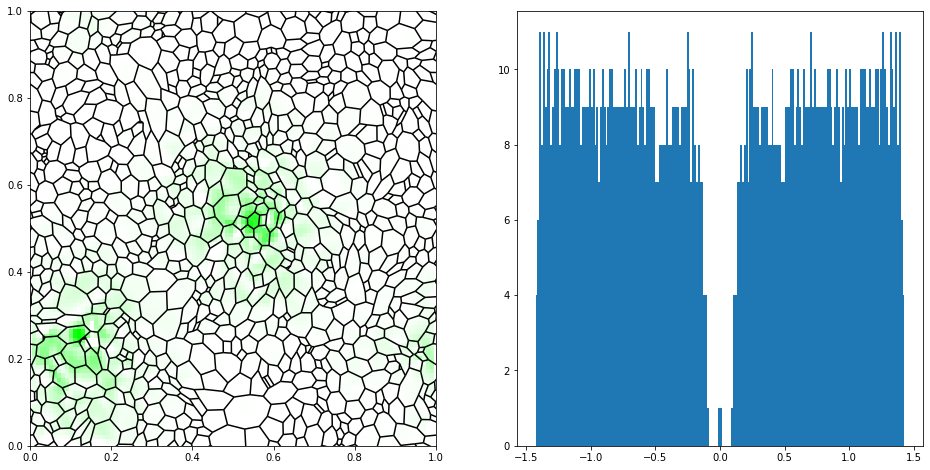

131it [00:18,  8.60it/s]

6.485352803394901e-06


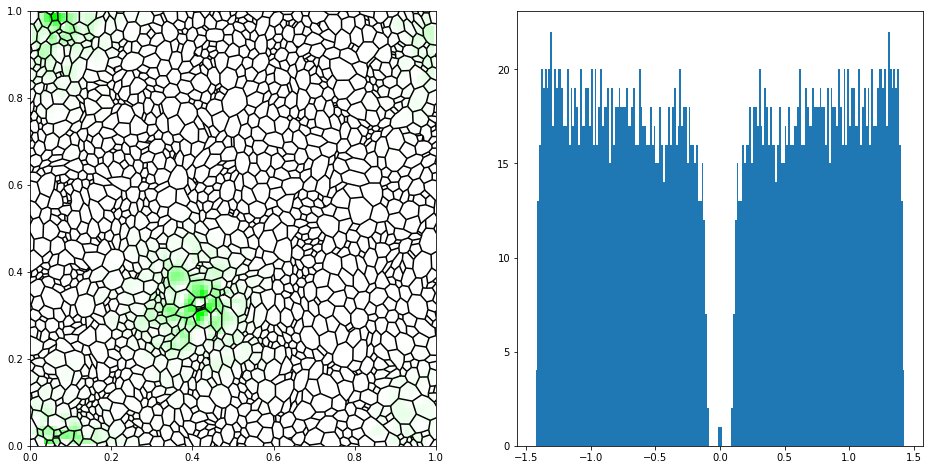

573it [01:23,  8.18it/s]

0.09189654931273017


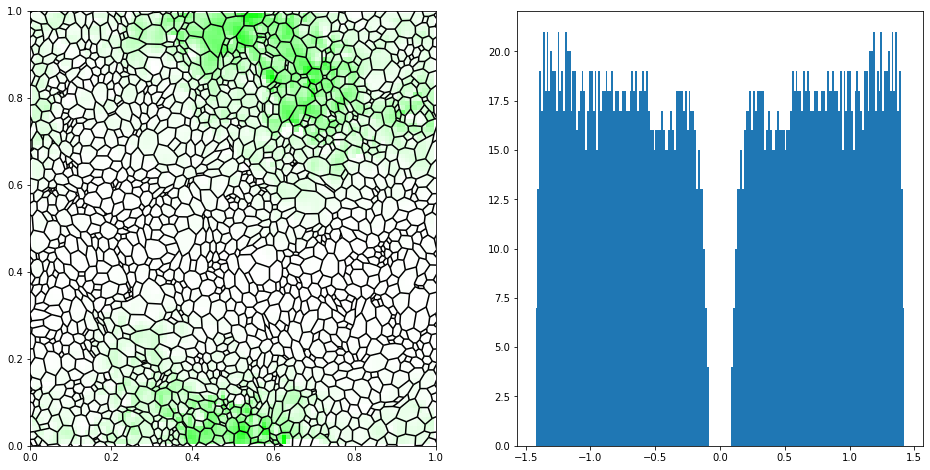

704it [01:50,  9.01it/s]

-0.09349746462970643


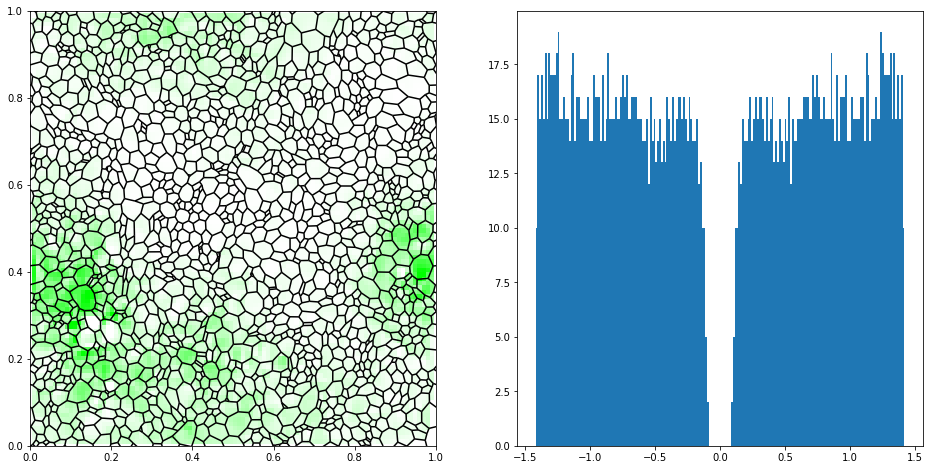

889it [02:19,  8.60it/s]

-0.09770479885326111


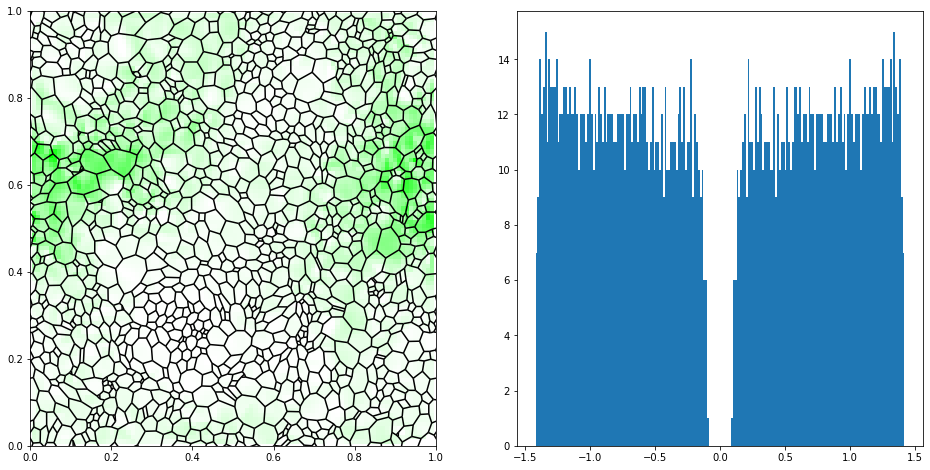

1005it [02:38,  6.32it/s]


KeyboardInterrupt: 

In [11]:
from koala.hamiltonian import generate_majorana_hamiltonian
from koala.graph_color import color_lattice
from koala.flux_finder import find_flux_sector
from scipy import linalg as la
from koala import plotting as pl
# now let's look at some of these near gapless states

gap_count = np.zeros(n_steps)

for u, names in tqdm(enumerate(zip(lattice_files, property_files))):
    assert(f_name[1] == p_name[1])
    f_name, p_name = names
    # open the relevant file

    
    with open(location + 'results/lattices/' + f_name , 'rb') as f_lat, open(location + 'results/properties/' + p_name , 'rb') as f_res:
        for n in range(n_steps):
            
            # get energies over k space and participation ratios
            e_values, p_ratios, _ = pickle.load(f_res) 
            
            lattice = pickle.load(f_lat)
            

            gap = np.min(np.abs(e_values))

            if gap <1e-5:
                gap_count[n] += 1

                if n>20:
                    colouring = color_lattice(lattice)
                    sides = np.array([p.n_sides for p in lattice.plaquettes])
                    flux = -(1j)**sides
                    f_real = flux.real + flux.imag

                    ujk = find_flux_sector(lattice, f_real)
                    h = generate_majorana_hamiltonian(lattice,colouring, ujk, np.array([1,1,1]))
                    e,v = la.eigh(h)
                    ind = np.argmin(np.abs(e))
                    print(e[ind])
                    fig, ax = plt.subplots(1,2 ,figsize = (16,8))
                    pl.plot_edges(lattice, ax = ax[0])
                    pl.plot_scalar(lattice, np.abs(v[:,ind]), vmin = 0, vmax = np.max(np.abs(v[:,ind])),ax = ax[0])

                    ax[1].hist(e, bins= 200)
                    plt.show()


In [ ]:


plt.plot(gap_count)